In [1]:
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from xgboost import plot_importance

/Users/TrevorE/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## XGBoost

### Without betting line

In [18]:
params = {'gamma': 10,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.5}
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
num_models = 10
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher','homeLine','awayLine'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    pred_avg = np.zeros(len(y_test))
    features = []

    for i in random.sample(range(1, 1000000), num_models): #[30, 595, 123, 4849, 3, 1010, 234, 8267, 3736, 99999]:
        clfi =  XGBClassifier(**params, silent=False, seed=i)
        clfi.fit(X_train, y_train.values.ravel())
        clfi_pred = clfi.predict(X_test) 
        pred_avg = pred_avg + (1/num_models)*clfi_pred
        features.append(clfi)

    pred_avg = np.round(pred_avg)
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred_avg)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred_avg)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.4601139601139601
Accuracy: 0.5398860398860399
Confusion matrix for XGBoost: 
[[ 49 268]
 [ 55 330]]

Year:  2011
Mean error rate: 0.45571428571428574
Accuracy: 0.5442857142857143
Confusion matrix for XGBoost: 
[[125 201]
 [118 256]]

Year:  2012
Mean error rate: 0.4458689458689459
Accuracy: 0.5541310541310541
Confusion matrix for XGBoost: 
[[ 98 219]
 [ 94 291]]

Year:  2013
Mean error rate: 0.43509272467902993
Accuracy: 0.5649072753209701
Confusion matrix for XGBoost: 
[[ 87 247]
 [ 58 309]]

Year:  2014
Mean error rate: 0.4642857142857143
Accuracy: 0.5357142857142857
Confusion matrix for XGBoost: 
[[144 166]
 [159 231]]

Year:  2015
Mean error rate: 0.4921540656205421
Accuracy: 0.5078459343794579
Confusion matrix for XGBoost: 
[[ 58 284]
 [ 61 298]]

Year:  2016
Mean error rate: 0.46494992846924177
Accuracy: 0.5350500715307582
Confusion matrix for XGBoost: 
[[ 84 251]
 [ 74 290]]

Year:  2017
Mean error rate: 0.4136947218259629
Accuracy: 0.5863052781740

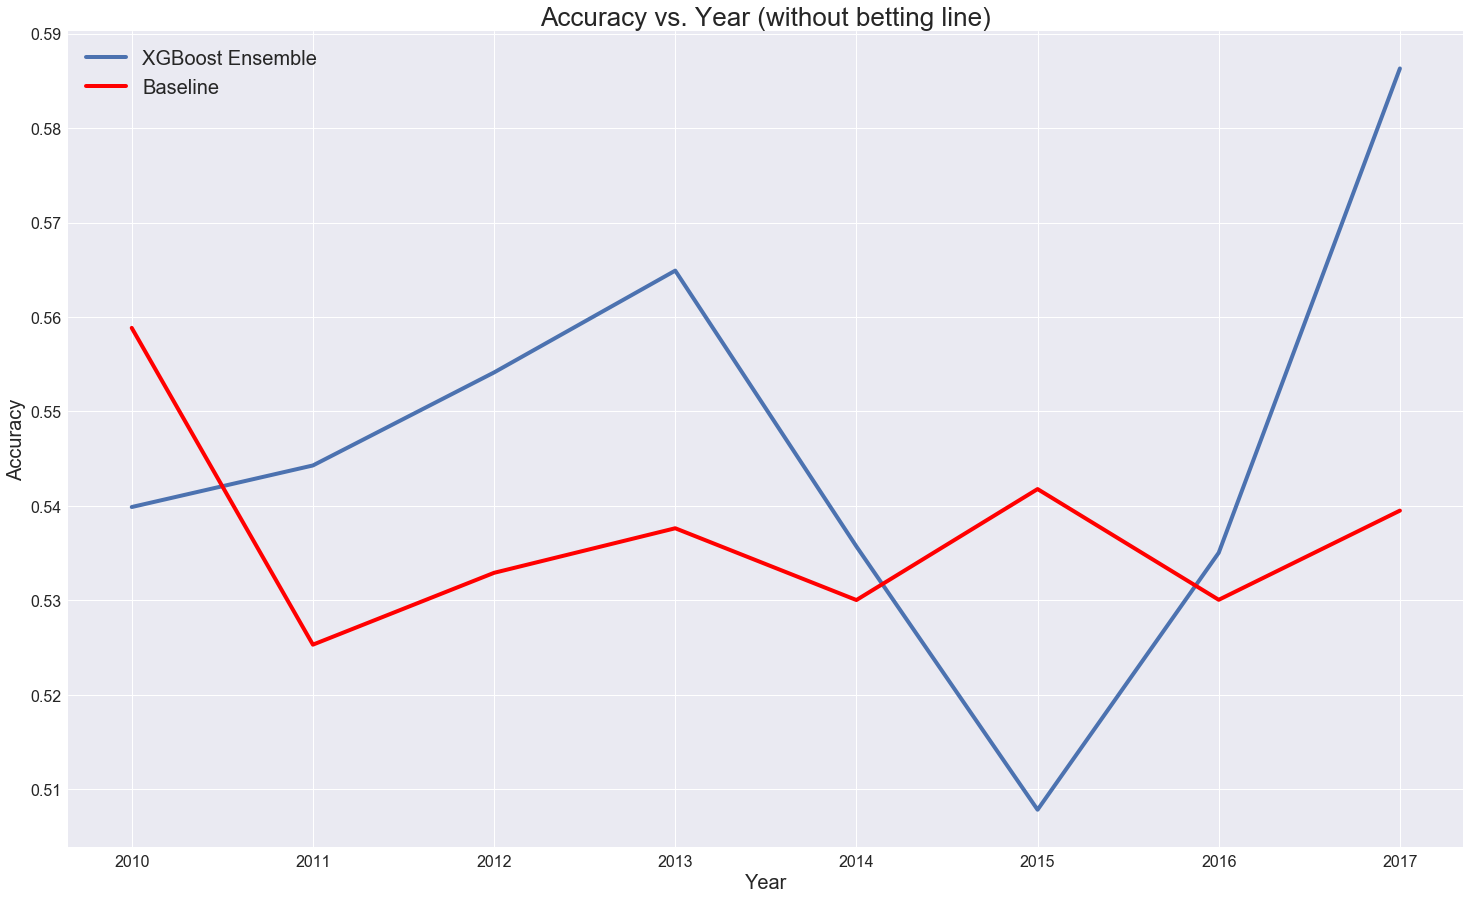

In [19]:
sns.set()
plt.figure(figsize=(25, 15))
plt.plot(years, accuracies, label='XGBoost Ensemble', linewidth=4)
plt.plot(years, baseline, color='red', label='Baseline', linewidth=4)
plt.title('Accuracy vs. Year (without betting line)',fontsize=26)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.show()

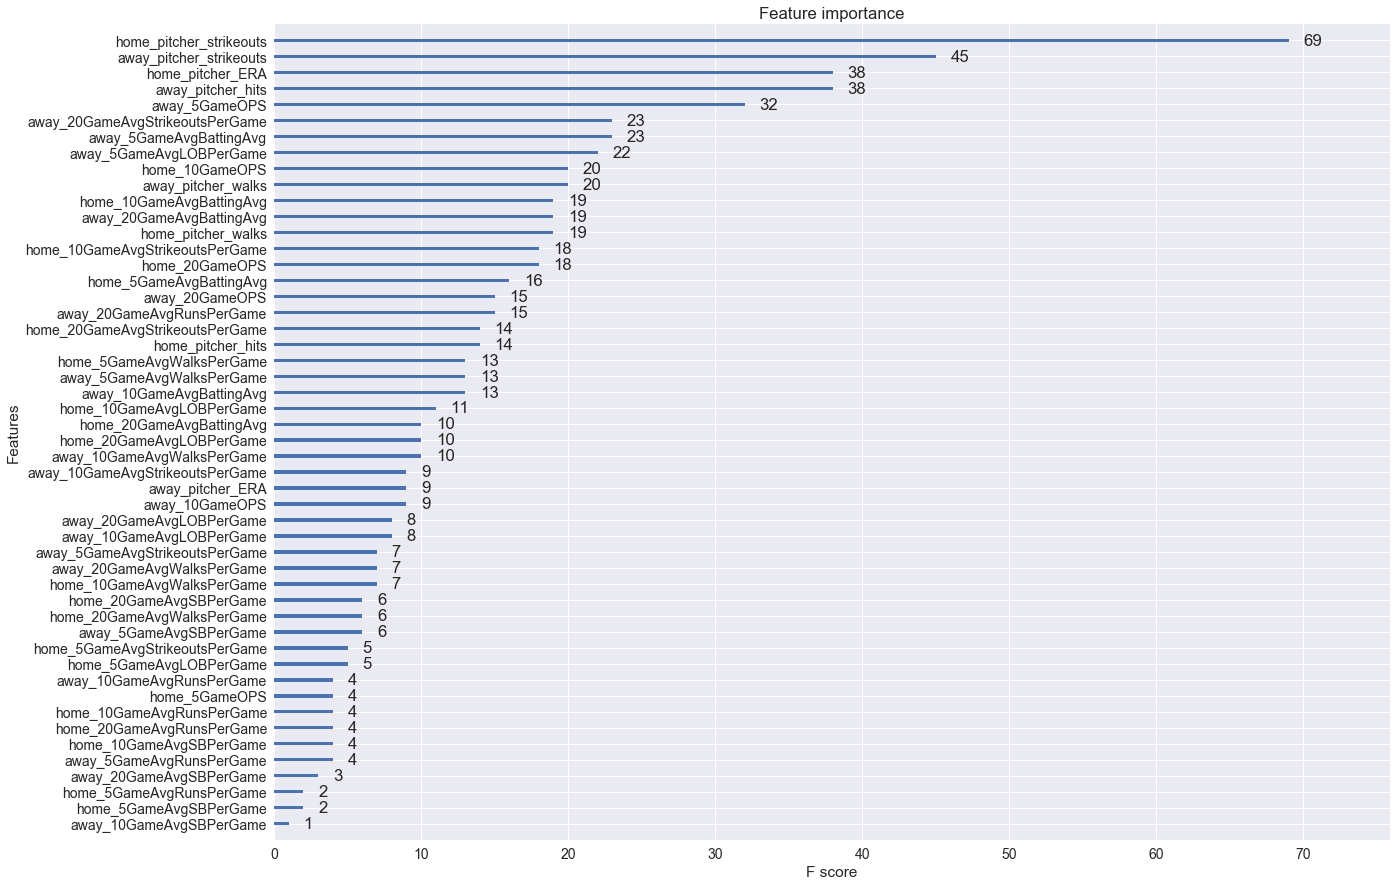

In [20]:
sns.set(font_scale=1.4)
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_importance(features[8], ax=ax)
plt.show()

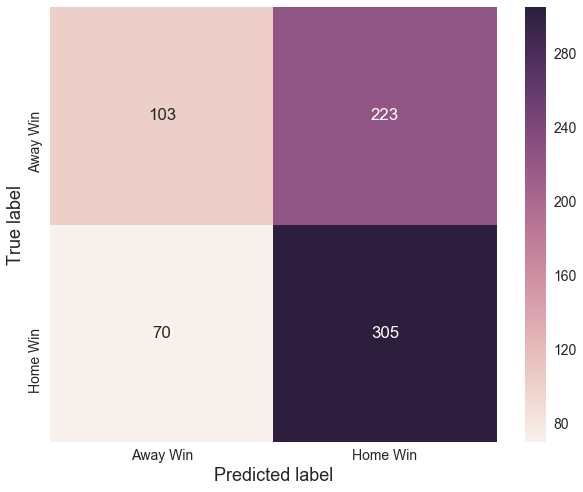

In [15]:
df_cm = pd.DataFrame(confusions[7], columns=['Away Win', 'Home Win'], index=['Away Win', 'Home Win'])
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.show()

### With betting line

In [16]:
params = {'gamma': 10,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.5}
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
num_models = 10
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    pred_avg = np.zeros(len(y_test))
    features = []

    for i in random.sample(range(1, 1000000), num_models): #[30, 595, 123, 4849, 3, 1010, 234, 8267, 3736, 99999]:
        clfi =  XGBClassifier(**params, silent=False, seed=i)
        clfi.fit(X_train, y_train.values.ravel())
        clfi_pred = clfi.predict(X_test) 
        pred_avg = pred_avg + (1/num_models)*clfi_pred
        features.append(clfi)

    pred_avg = np.round(pred_avg)
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred_avg)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred_avg)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.4672364672364673
Accuracy: 0.5327635327635327
Confusion matrix for XGBoost: 
[[ 76 241]
 [ 87 298]]

Year:  2011
Mean error rate: 0.41000000000000003
Accuracy: 0.59
Confusion matrix for XGBoost: 
[[173 153]
 [134 240]]

Year:  2012
Mean error rate: 0.4301994301994302
Accuracy: 0.5698005698005698
Confusion matrix for XGBoost: 
[[125 192]
 [110 275]]

Year:  2013
Mean error rate: 0.41512125534950073
Accuracy: 0.5848787446504993
Confusion matrix for XGBoost: 
[[142 192]
 [ 99 268]]

Year:  2014
Mean error rate: 0.43714285714285717
Accuracy: 0.5628571428571428
Confusion matrix for XGBoost: 
[[171 139]
 [167 223]]

Year:  2015
Mean error rate: 0.4393723252496433
Accuracy: 0.5606276747503567
Confusion matrix for XGBoost: 
[[100 242]
 [ 66 293]]

Year:  2016
Mean error rate: 0.4291845493562232
Accuracy: 0.5708154506437768
Confusion matrix for XGBoost: 
[[123 212]
 [ 88 276]]

Year:  2017
Mean error rate: 0.4194008559201141
Accuracy: 0.5805991440798859
Confusion 

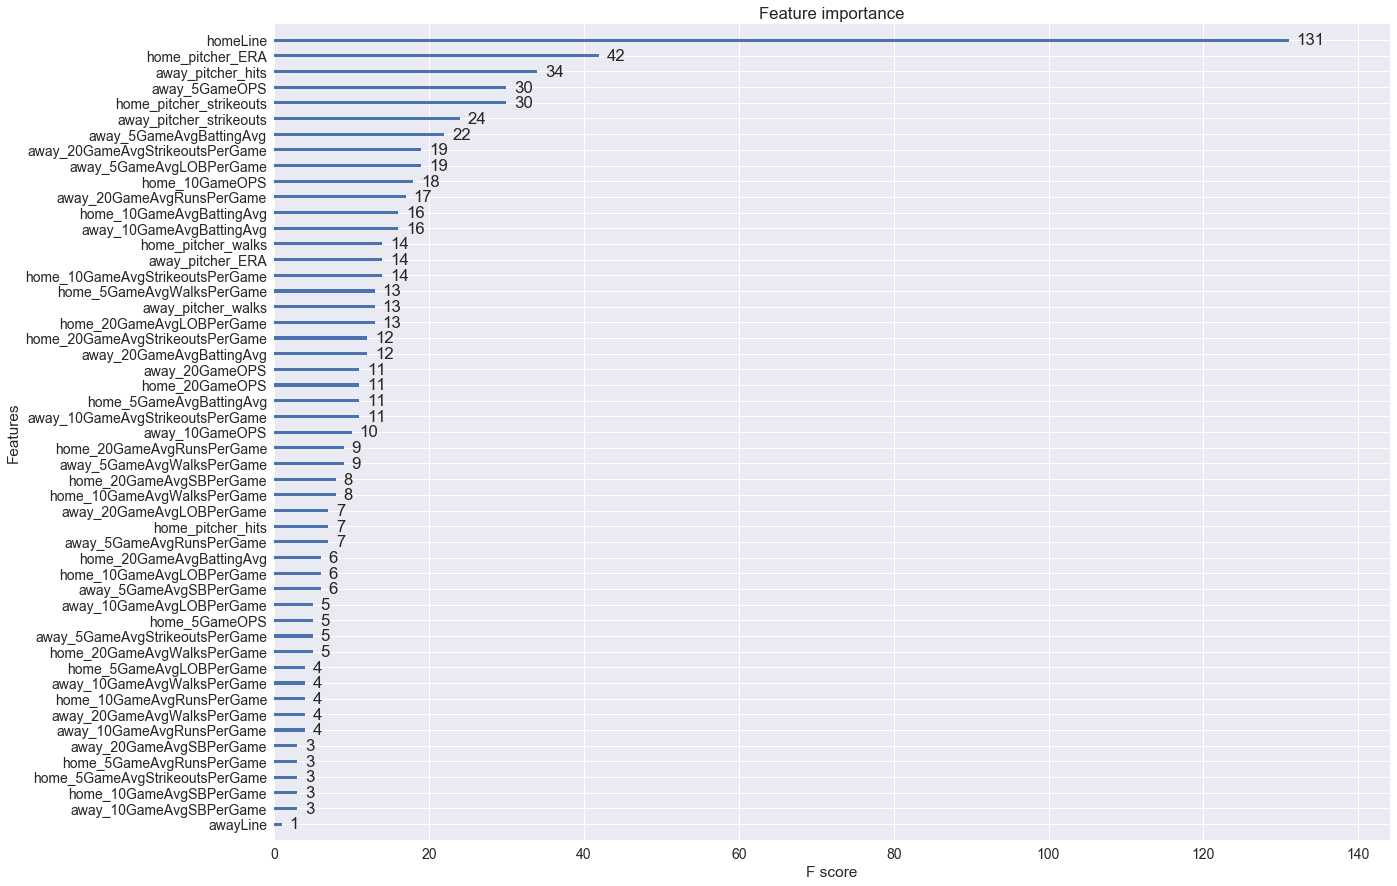

In [17]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_importance(features[8], ax=ax)
plt.show()

## Random Forest

### Without betting line

In [36]:
rf_params = {
    'max_depth' : 100,
    'max_features' : 44, 
    'n_estimators' : 200
}

year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher','homeLine','awayLine'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.4757834757834758
Accuracy: 0.5242165242165242
Confusion matrix for XGBoost: 
[[ 93 224]
 [110 275]]

Year:  2011
Mean error rate: 0.4742857142857143
Accuracy: 0.5257142857142857
Confusion matrix for XGBoost: 
[[154 172]
 [160 214]]

Year:  2012
Mean error rate: 0.4700854700854701
Accuracy: 0.5299145299145299
Confusion matrix for XGBoost: 
[[125 192]
 [138 247]]

Year:  2013
Mean error rate: 0.4621968616262482
Accuracy: 0.5378031383737518
Confusion matrix for XGBoost: 
[[130 204]
 [120 247]]

Year:  2014
Mean error rate: 0.4771428571428571
Accuracy: 0.5228571428571429
Confusion matrix for XGBoost: 
[[162 148]
 [186 204]]

Year:  2015
Mean error rate: 0.48074179743223966
Accuracy: 0.5192582025677603
Confusion matrix for XGBoost: 
[[116 226]
 [111 248]]

Year:  2016
Mean error rate: 0.469241773962804
Accuracy: 0.530758226037196
Confusion matrix for XGBoost: 
[[118 217]
 [111 253]]

Year:  2017
Mean error rate: 0.4621968616262482
Accuracy: 0.5378031383737518


### With betting line

In [38]:
rf_params = {
    'max_depth' : 100,
    'max_features' : 44, 
    'n_estimators' : 200
}

year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.47150997150997154
Accuracy: 0.5284900284900285
Confusion matrix for XGBoost: 
[[ 87 230]
 [101 284]]

Year:  2011
Mean error rate: 0.4342857142857143
Accuracy: 0.5657142857142857
Confusion matrix for XGBoost: 
[[159 167]
 [137 237]]

Year:  2012
Mean error rate: 0.46438746438746437
Accuracy: 0.5356125356125356
Confusion matrix for XGBoost: 
[[133 184]
 [142 243]]

Year:  2013
Mean error rate: 0.41226818830242506
Accuracy: 0.5877318116975749
Confusion matrix for XGBoost: 
[[151 183]
 [106 261]]

Year:  2014
Mean error rate: 0.4542857142857143
Accuracy: 0.5457142857142857
Confusion matrix for XGBoost: 
[[174 136]
 [182 208]]

Year:  2015
Mean error rate: 0.44507845934379453
Accuracy: 0.5549215406562055
Confusion matrix for XGBoost: 
[[131 211]
 [101 258]]

Year:  2016
Mean error rate: 0.4391988555078684
Accuracy: 0.5608011444921316
Confusion matrix for XGBoost: 
[[134 201]
 [106 258]]

Year:  2017
Mean error rate: 0.449358059914408
Accuracy: 0.5506419400855

## SVM

### Without betting line

In [27]:
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher','homeLine','awayLine'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    svm = SVC(C=1)
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.4658119658119658
Accuracy: 0.5341880341880342
Confusion matrix for XGBoost: 
[[ 57 260]
 [ 67 318]]

Year:  2011
Mean error rate: 0.4585714285714285
Accuracy: 0.5414285714285715
Confusion matrix for XGBoost: 
[[140 186]
 [135 239]]

Year:  2012
Mean error rate: 0.4686609686609686
Accuracy: 0.5313390313390314
Confusion matrix for XGBoost: 
[[104 213]
 [116 269]]

Year:  2013
Mean error rate: 0.4664764621968617
Accuracy: 0.5335235378031383
Confusion matrix for XGBoost: 
[[ 79 255]
 [ 72 295]]

Year:  2014
Mean error rate: 0.4642857142857143
Accuracy: 0.5357142857142857
Confusion matrix for XGBoost: 
[[149 161]
 [164 226]]

Year:  2015
Mean error rate: 0.4864479315263909
Accuracy: 0.5135520684736091
Confusion matrix for XGBoost: 
[[ 65 277]
 [ 64 295]]

Year:  2016
Mean error rate: 0.46494992846924177
Accuracy: 0.5350500715307582
Confusion matrix for XGBoost: 
[[100 235]
 [ 90 274]]

Year:  2017
Mean error rate: 0.45078459343794575
Accuracy: 0.54921540656205

### With betting line

In [40]:
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    svm = SVC(C=1)
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.45584045584045585
Accuracy: 0.5441595441595442
Confusion matrix for XGBoost: 
[[ 87 230]
 [ 90 295]]

Year:  2011
Mean error rate: 0.4571428571428572
Accuracy: 0.5428571428571428
Confusion matrix for XGBoost: 
[[172 154]
 [166 208]]

Year:  2012
Mean error rate: 0.4544159544159544
Accuracy: 0.5455840455840456
Confusion matrix for XGBoost: 
[[129 188]
 [131 254]]

Year:  2013
Mean error rate: 0.43081312410841655
Accuracy: 0.5691868758915835
Confusion matrix for XGBoost: 
[[147 187]
 [115 252]]

Year:  2014
Mean error rate: 0.4571428571428572
Accuracy: 0.5428571428571428
Confusion matrix for XGBoost: 
[[154 156]
 [164 226]]

Year:  2015
Mean error rate: 0.4379457917261056
Accuracy: 0.5620542082738944
Confusion matrix for XGBoost: 
[[114 228]
 [ 79 280]]

Year:  2016
Mean error rate: 0.4334763948497854
Accuracy: 0.5665236051502146
Confusion matrix for XGBoost: 
[[132 203]
 [100 264]]

Year:  2017
Mean error rate: 0.4393723252496433
Accuracy: 0.56062767475035

## Logistic Regression

### Without betting line

In [28]:
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher','homeLine','awayLine'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    reg = LogisticRegression()
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1

print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.4757834757834758
Accuracy: 0.5242165242165242
Confusion matrix for XGBoost: 
[[ 81 236]
 [ 98 287]]

Year:  2011
Mean error rate: 0.47
Accuracy: 0.53
Confusion matrix for XGBoost: 
[[132 194]
 [135 239]]

Year:  2012
Mean error rate: 0.45868945868945865
Accuracy: 0.5413105413105413
Confusion matrix for XGBoost: 
[[107 210]
 [112 273]]

Year:  2013
Mean error rate: 0.4436519258202568
Accuracy: 0.5563480741797432
Confusion matrix for XGBoost: 
[[127 207]
 [104 263]]

Year:  2014
Mean error rate: 0.4571428571428572
Accuracy: 0.5428571428571428
Confusion matrix for XGBoost: 
[[155 155]
 [165 225]]

Year:  2015
Mean error rate: 0.4864479315263909
Accuracy: 0.5135520684736091
Confusion matrix for XGBoost: 
[[ 73 269]
 [ 72 287]]

Year:  2016
Mean error rate: 0.4277539341917024
Accuracy: 0.5722460658082976
Confusion matrix for XGBoost: 
[[132 203]
 [ 96 268]]

Year:  2017
Mean error rate: 0.47075606276747506
Accuracy: 0.5292439372325249
Confusion matrix for XGBo

### With betting line

In [41]:
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    reg = LogisticRegression()
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1

print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.4672364672364673
Accuracy: 0.5327635327635327
Confusion matrix for XGBoost: 
[[ 98 219]
 [109 276]]

Year:  2011
Mean error rate: 0.44285714285714284
Accuracy: 0.5571428571428572
Confusion matrix for XGBoost: 
[[155 171]
 [139 235]]

Year:  2012
Mean error rate: 0.45299145299145294
Accuracy: 0.5470085470085471
Confusion matrix for XGBoost: 
[[128 189]
 [129 256]]

Year:  2013
Mean error rate: 0.41084165477888734
Accuracy: 0.5891583452211127
Confusion matrix for XGBoost: 
[[147 187]
 [101 266]]

Year:  2014
Mean error rate: 0.4442857142857143
Accuracy: 0.5557142857142857
Confusion matrix for XGBoost: 
[[168 142]
 [169 221]]

Year:  2015
Mean error rate: 0.44507845934379453
Accuracy: 0.5549215406562055
Confusion matrix for XGBoost: 
[[116 226]
 [ 86 273]]

Year:  2016
Mean error rate: 0.41487839771101576
Accuracy: 0.5851216022889842
Confusion matrix for XGBoost: 
[[147 188]
 [102 262]]

Year:  2017
Mean error rate: 0.46077032810271046
Accuracy: 0.5392296718

## MLP

### Without betting line

In [42]:
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher','homeLine','awayLine'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    mlp = MLPClassifier(solver='sgd', learning_rate='adaptive', hidden_layer_sizes=(30, 20))
    mlp.fit(X_train, y_train)
    pred = mlp.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.46153846153846156
Accuracy: 0.5384615384615384
Confusion matrix for XGBoost: 
[[ 58 259]
 [ 65 320]]

Year:  2011
Mean error rate: 0.44571428571428573
Accuracy: 0.5542857142857143
Confusion matrix for XGBoost: 
[[152 174]
 [138 236]]

Year:  2012
Mean error rate: 0.45014245014245013
Accuracy: 0.5498575498575499
Confusion matrix for XGBoost: 
[[ 39 278]
 [ 38 347]]

Year:  2013
Mean error rate: 0.4964336661911555
Accuracy: 0.5035663338088445
Confusion matrix for XGBoost: 
[[ 54 280]
 [ 68 299]]

Year:  2014
Mean error rate: 0.4571428571428572
Accuracy: 0.5428571428571428
Confusion matrix for XGBoost: 
[[129 181]
 [139 251]]

Year:  2015
Mean error rate: 0.47075606276747506
Accuracy: 0.5292439372325249
Confusion matrix for XGBoost: 
[[ 69 273]
 [ 57 302]]

Year:  2016
Mean error rate: 0.48068669527897
Accuracy: 0.51931330472103
Confusion matrix for XGBoost: 
[[ 93 242]
 [ 94 270]]

Year:  2017
Mean error rate: 0.4393723252496433
Accuracy: 0.5606276747503567

### With betting line

In [46]:
year = 2010
years = [2010+i for i in range(8)]
baseline = [0.5588477366255145, 0.5253190613421161, 0.5329218106995884, 0.5376388317564789, 0.5300411522633744, 0.541786743515850,
            0.5300658978583196, 0.5395061728395062]

accuracies = []
confusions = []
features = []
for i in range(8):
    # Read in dataset
    df = pd.read_csv('Rolling Average Stats/' + str(year) +'.csv')

    # Create observation and labels
    X = df.drop(['date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_pitcher', 'away_pitcher'], 1)
    y = df.home_score > df.away_score # 1 if home team wins, 0 otherwise
    # Use 1st 2/3rds of season for training, test on last 1/3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
    features = []
    mlp = MLPClassifier(solver='sgd', learning_rate='adaptive', hidden_layer_sizes=(30, 20))
    mlp.fit(X_train, y_train)
    pred = mlp.predict(X_test)
    
    # Report mean error rate
    accuracy = accuracy_score(y_test, pred)
    error_rate = 1 - accuracy
    print('Year: ', year)
    print("Mean error rate: {}\nAccuracy: {}".format(error_rate, accuracy))
    accuracies.append(accuracy)

    # Report confusion matrix for each classifier
    confusion = confusion_matrix(y_test, pred)
    print("Confusion matrix for XGBoost: \n{}\n".format(confusion))
    confusions.append(confusion)
    year += 1
    
print('Average accuracy: ', np.mean(accuracies))

Year:  2010
Mean error rate: 0.43732193732193736
Accuracy: 0.5626780626780626
Confusion matrix for XGBoost: 
[[ 98 219]
 [ 88 297]]

Year:  2011
Mean error rate: 0.4214285714285714
Accuracy: 0.5785714285714286
Confusion matrix for XGBoost: 
[[170 156]
 [139 235]]

Year:  2012
Mean error rate: 0.4145299145299145
Accuracy: 0.5854700854700855
Confusion matrix for XGBoost: 
[[118 199]
 [ 92 293]]

Year:  2013
Mean error rate: 0.42082738944365194
Accuracy: 0.579172610556348
Confusion matrix for XGBoost: 
[[114 220]
 [ 75 292]]

Year:  2014
Mean error rate: 0.39
Accuracy: 0.61
Confusion matrix for XGBoost: 
[[109 201]
 [ 72 318]]

Year:  2015
Mean error rate: 0.40513552068473613
Accuracy: 0.5948644793152639
Confusion matrix for XGBoost: 
[[107 235]
 [ 49 310]]

Year:  2016
Mean error rate: 0.40629470672389123
Accuracy: 0.5937052932761088
Confusion matrix for XGBoost: 
[[151 184]
 [100 264]]

Year:  2017
Mean error rate: 0.41654778887303856
Accuracy: 0.5834522111269614
Confusion matrix for XG

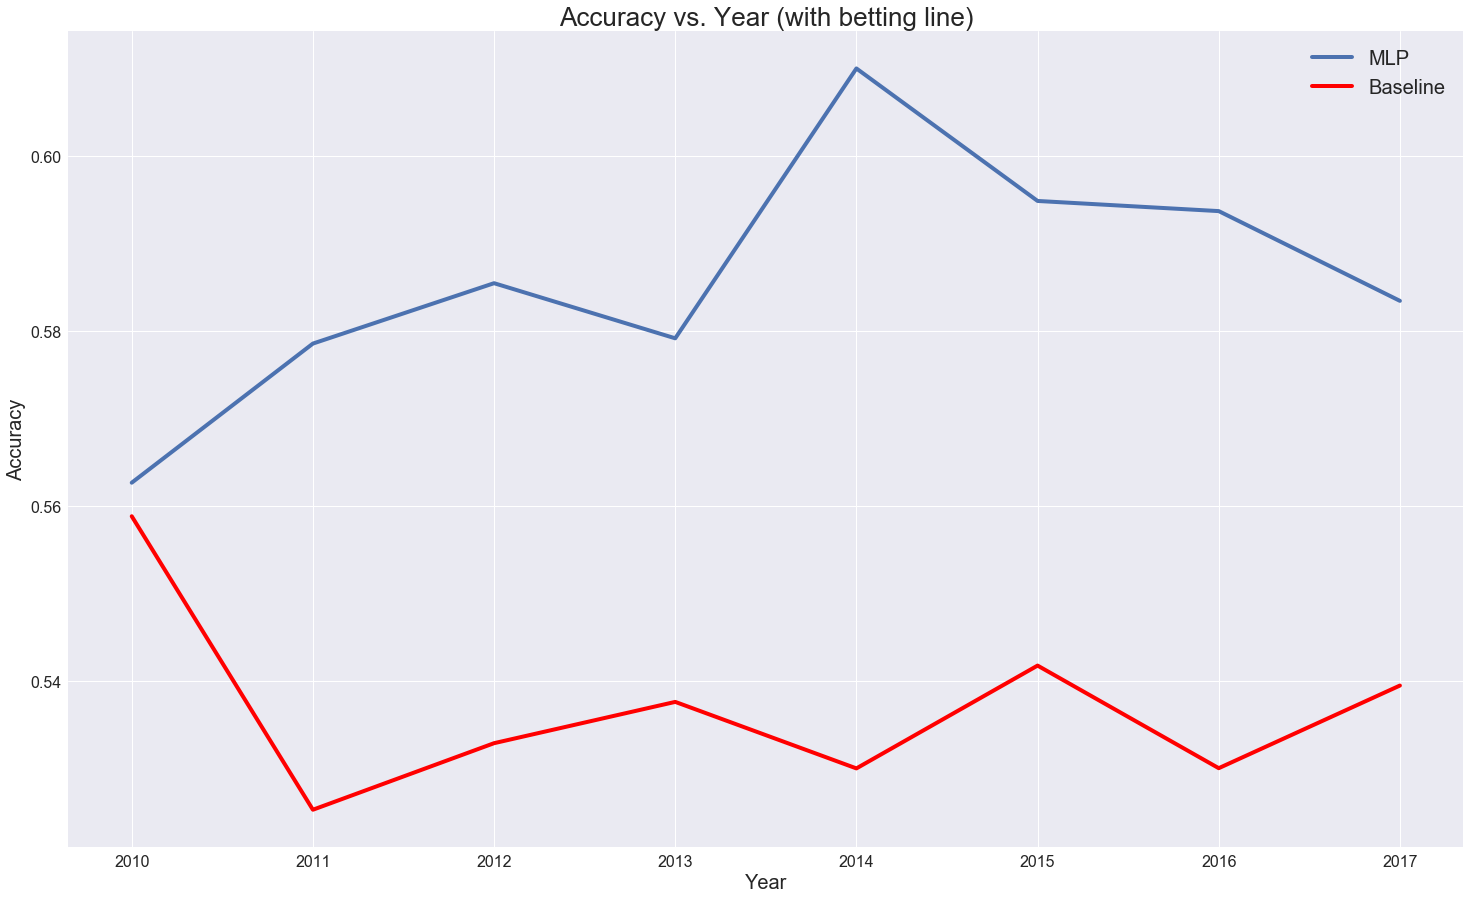

In [47]:
sns.set()
plt.figure(figsize=(25, 15))
plt.plot(years, accuracies, label='MLP', linewidth=4)
plt.plot(years, baseline, color='red', label='Baseline', linewidth=4)
plt.title('Accuracy vs. Year (with betting line)',fontsize=26)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.show()

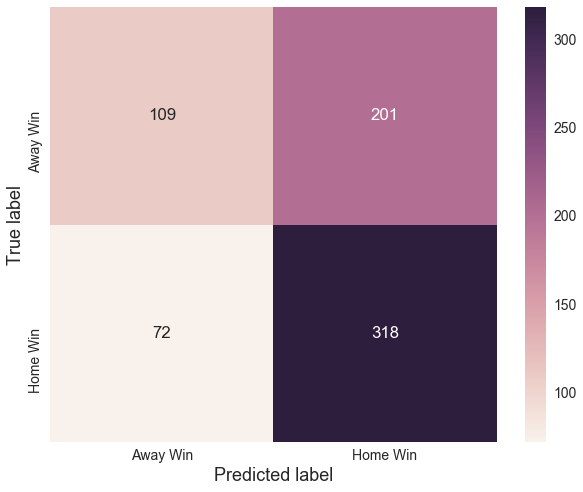

In [48]:
df_cm = pd.DataFrame(confusions[4], columns=['Away Win', 'Home Win'], index=['Away Win', 'Home Win'])
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.show()